In [208]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import cv2
import time
import os

In [209]:
class Vehicle:
    def __init__(self, current_x, current_v, current_s,vehicle_length, delta_t, lane_length, global_clock):
        self.current_x = current_x
        self.current_v = current_v
        self.current_a = 0
        self.current_s = 10000  # Initially set to a large value
        self.delta_t = delta_t
        self.vehicle_length = vehicle_length
        self.lane_length = lane_length

        self.history_t = [global_clock]
        self.history_x = [current_x]
        self.history_v = [current_v]
        self.history_a = [0]
        self.history_s = [current_s]
        self.history_delta_v = []

        # Simulate lane changing behavior, random generate when initialization (m)
        self.desired_lane_change_distance = None
        # IDM parameters
        self.v0 = 25 + np.random.normal(0,1) # Desired velocity
        self.T = 1.5    # Safe time headway
        self.a = 0.3 + np.random.normal(0.01)   # Maximum acceleration
        if self.a < 0.2:
            self.a = 0.2
        self.b = 3  + np.random.normal(0.03)  # Comfortable deceleration
        if self.b < 2:
            self.b = 2
        self.delta = 4  # Acceleration exponent
        self.s0 = 0.5 + np.random.rand() # Minimum gap
        self.red_visual_distance = np.random.normal(100, 5)  # Distance at which vehicle will stop for red light
        self.stopped_at_red = False
        self.stop_for_red = True

    def update(self, lead_vehicle, is_red_light, global_clock):

        # Update s (distance to leading vehicle or traffic light)
        if lead_vehicle:
            self.current_s = lead_vehicle.current_x - self.current_x - lead_vehicle.vehicle_length
        elif is_red_light and self.stop_for_red:
            self.current_s = max(0, self.lane_length - self.current_x)
        else:
            self.current_s = 10000  # Large value for free driving

        # Calculate acceleration using IDM
        lead_v = lead_vehicle.current_v if lead_vehicle else self.v0
        if is_red_light and self.stop_for_red and self.current_s < self.red_visual_distance :  # Close to red light
            lead_v = 0
        delta_v = self.current_v - lead_v
        s_star = (self.s0 + max(0, self.current_v * self.T + 
                  (self.current_v * delta_v) / 
                  (2 * np.sqrt(self.a * self.b))))
        
        self.current_a = self.a * (1 - (self.current_v / self.v0)**self.delta - (s_star / max(self.current_s, 0.01))**2)
        if self.current_a < -8:
            self.current_a = -8
        if self.current_a > 3:
            self.current_a = 3
        # Update velocity and position
        self.current_v = max(0, self.current_v + self.current_a * self.delta_t)
        self.current_x = min(self.lane_length, self.current_x + self.current_v * self.delta_t)

        # Save to history
        self.history_t.append(global_clock)
        self.history_x.append(self.current_x)
        self.history_v.append(self.current_v)
        self.history_a.append(self.current_a)
        self.history_s.append(self.current_s)
        self.history_delta_v.append(delta_v)

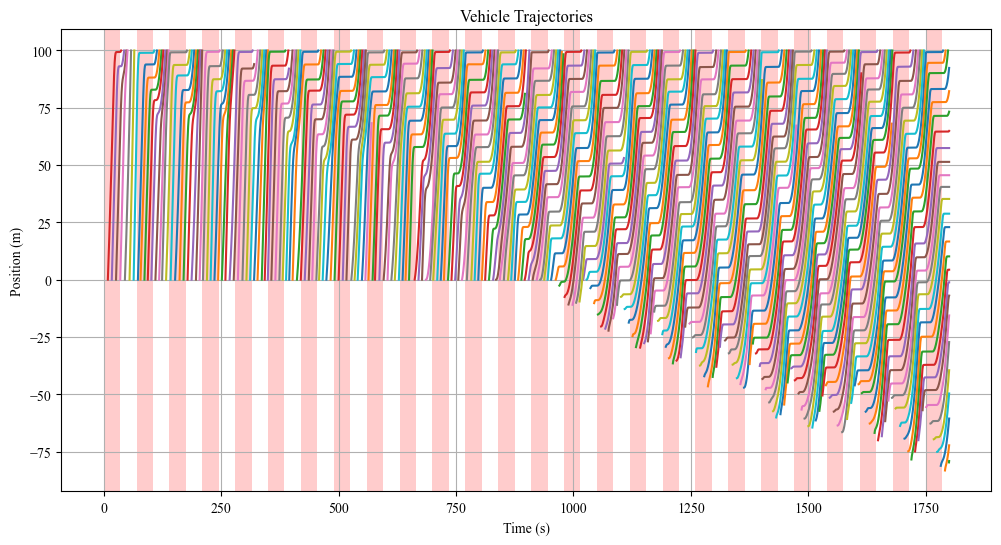

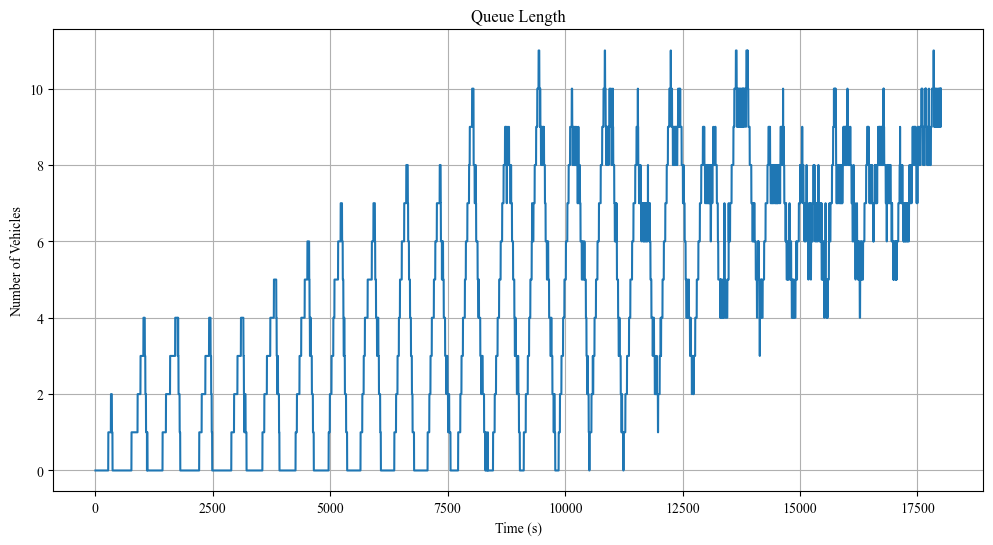

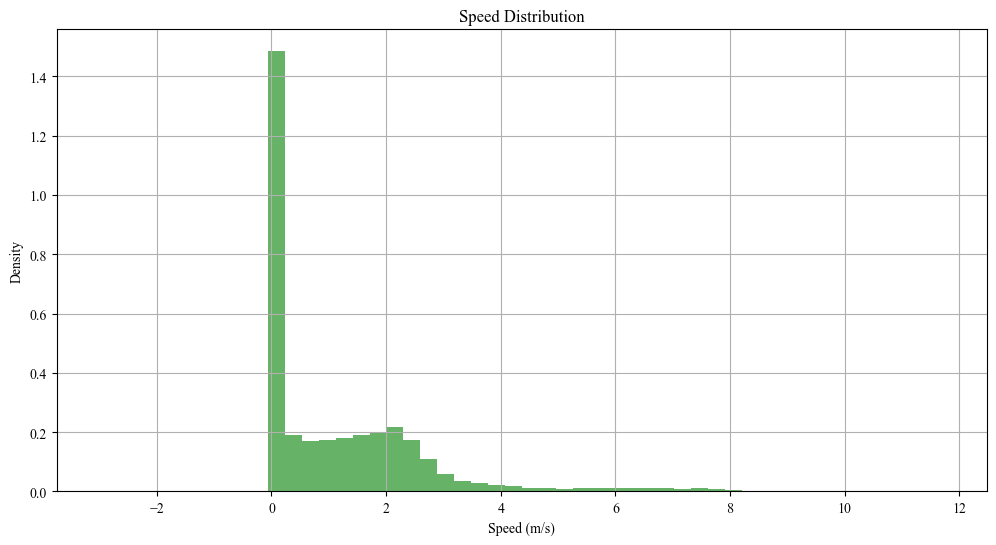

In [210]:

def run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed, lane_change_prob, mean_vehicle_length = 5):
    # Initialize variables
    mean_vehicle_length = 5
    # mean_speed = 10 # m/s

    vehicles = []
    exited_vehicles = []
    global_clock = 0
    next_vehicle_time = np.random.normal(mean_headway, 2)
    queue_record = [] # Queue of vehicles whose speed is 0
    num_vehicles = [] # Number of vehicles in the lane
    
    # Simulation loop
    while global_clock < simulation_time:
        light_cycle = red_light_time + green_light_time
        is_red_light = (global_clock % light_cycle) < red_light_time

        # Generate new vehicle if it's time
        if global_clock >= next_vehicle_time:
            vehicle_length = np.random.normal(mean_vehicle_length, 0.5)
            
            if vehicles:
                # Consider the tail car's speed and position
                tail_car = vehicles[-1]
                current_v = np.random.normal(tail_car.current_v, 1)
                # Position the new car behind the tail car, allowing negative positions
                if tail_car.current_x - tail_car.vehicle_length < 0:
                    current_x = tail_car.current_x - tail_car.vehicle_length - tail_car.s0 - 0.2 * vehicle_length
                    current_s = tail_car.s0 + 0.2 * vehicle_length
                else:
                    current_x = 0
                    current_s = tail_car.current_x - tail_car.vehicle_length
            else:
                current_v = np.random.normal(mean_speed, 5)
                if current_v < 0:
                    current_v = 1
                current_x = 0
                current_s = 10000
            new_vehicle = Vehicle(current_x, current_v, current_s,vehicle_length, delta_t, lane_length, global_clock)
            if np.random.rand() < lane_change_prob:
                # select a distance that the in the last half of the lane distance
                new_vehicle.desired_lane_change_distance = lane_length - np.random.randint(0, int(lane_length/2))
            vehicles.append(new_vehicle)
            next_vehicle_time = global_clock + np.random.normal(mean_headway, 1)
        global_clock += delta_t
        # Update vehicles and check for exits
        i = 0
        queue_num = 0
        while i < len(vehicles):
            vehicle = vehicles[i]
            lead_vehicle = vehicles[i-1] if i > 0 else None
            vehicle.update(lead_vehicle, is_red_light, global_clock)
            # Check if vehicle has exited the lane
            if vehicle.current_x >= lane_length:
                exited_vehicles.append(vehicles.pop(i))
            elif vehicle.desired_lane_change_distance is not None and vehicle.current_x > vehicle.desired_lane_change_distance :
                exited_vehicles.append(vehicles.pop(i))
            else:
                i += 1
            # Check if vehicle is stopped
            if vehicle.current_v == 0:
                queue_num += 1
        queue_record.append(queue_num)
        num_vehicles.append(len(vehicles))
    queue_record = np.array(queue_record)
    num_vehicles = np.array(num_vehicles) 

    return vehicles, exited_vehicles, queue_record, num_vehicles

# Run simulation
lane_length = 100  # meters
simulation_time = 1800  # seconds
delta_t = 0.1  # seconds

red_light_time = 35
green_light_time = 35



mean_headway = 8
mean_speed = 10 
lane_change_prob = 0.06
vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob )
total_vehicles = vehicles + exited_vehicles

# Plotting
plt.figure(figsize=(12, 6))
for vehicle in vehicles + exited_vehicles:
    plt.plot(vehicle.history_t, vehicle.history_x)

plt.title('Vehicle Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid(True)

# Add traffic light cycle visualization
for i in range(int(simulation_time / (red_light_time + green_light_time)) + 1):
    plt.axvspan(i * (red_light_time + green_light_time), (i * (red_light_time + green_light_time)) + red_light_time, 
                facecolor='red', alpha=0.2)

plt.show()
# plot queue length curve
plt.figure(figsize=(12, 6))
plt.plot(range(len(queue_record)), queue_record)
plt.title('Queue Length')
plt.xlabel('Time (s)')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()
speed_profile = []
for vehicle in total_vehicles:
    speed_profile.append(vehicle.history_v)
speed_profile = np.concatenate(speed_profile)
# plot distribution of speed
plt.figure(figsize=(12, 6))
plt.hist(speed_profile, bins=50, density=True, alpha=0.6, color='g')
plt.title('Speed Distribution')
plt.xlabel('Speed (m/s)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [211]:
def create_time_space_diagram(vehicles, lane_length, simulation_time, delta_t,delta_x):
    # Set up the grid
    time_resolution = delta_t # seconds per pixel
    space_resolution = delta_x  # meters per pixel
    time_pixels = int(simulation_time / time_resolution)
    space_pixels = int(lane_length / space_resolution)
    
    # Create an empty grid
    time_space_mask = np.zeros((space_pixels, time_pixels), dtype=int)
    time_space_mask_occ_effect = np.zeros((space_pixels, time_pixels), dtype=int) # this is for simulate the effect of the vehicle length on the space (some part of the vehicle cannot be observed)
    vehicle_trajs = []
    for v_id,vehicle in enumerate(vehicles):
        vehicle_length_pixels = int(vehicle.vehicle_length / space_resolution)
        for t, x, v in zip(vehicle.history_t, vehicle.history_x, vehicle.history_v):
            time_idx = int(t / time_resolution) - 1
            space_idx = int(x / space_resolution) - 1
            if 0 <= space_idx < space_pixels:
                vehicle_trajs.append((v_id, time_idx, space_idx, v))
                # Mark the space occupied by the vehicle
                length_decay = x / lane_length
                preserved_pixels_occ = int(vehicle_length_pixels * length_decay) - np.random.randint(0,6)
                if preserved_pixels_occ < 0:
                    preserved_pixels_occ = 0
                for i in range(vehicle_length_pixels):
                    if 0 <= space_idx - i < space_pixels:
                        time_space_mask[space_idx - i, time_idx] = 1

                for i in range(preserved_pixels_occ):
                    if 0 <= space_idx - i < space_pixels:
                        time_space_mask_occ_effect[space_idx - i, time_idx] = 1
                        
    return time_space_mask,time_space_mask_occ_effect,vehicle_trajs

# After running the simulation
time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(vehicles + exited_vehicles, lane_length, simulation_time, delta_t,0.5)

In [212]:
# Randomly add some regular patches with angles to block the time_space_mask to simulate the occlusion events
def add_occlusions(binary_mask):
    # Convert binary mask to uint8 type (required for OpenCV operations)
    occluded_mask = (binary_mask * 1).astype(np.uint8)
    occlusion_mask = np.zeros_like(occluded_mask) # indicating the occlusion area where the binary mask is 1 and the occlusion is 0
    num_occlusions = occluded_mask.shape[1] // 20
    height, width = occluded_mask.shape
    for _ in range(num_occlusions):
        # Random center point
        center = (np.random.randint(0, width), np.random.randint(0, height))
        
        # Random width and height (between 5% and 20% of image dimensions)
        rect_width = int(np.random.normal(12,2))
        rect_height = int(np.random.normal(60,3))
        
        # Random angle (0 to 180 degrees)
        angle = np.random.randint(0, 45)
        
        # Create rotated rectangle
        rect = ((center[0], center[1]), (rect_width, rect_height), angle)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        
        # Fill the rotated rectangle with white (255)
        cv2.fillPoly(occlusion_mask, [box], 1)
        cv2.fillPoly(occluded_mask, [box], 0)
    # find common area of occlusion and binary mask
    occlusion_mask = occlusion_mask * binary_mask
    
    return occluded_mask,occlusion_mask

# add noise to the occulded diagram
def add_noise(binary_mask,emit_rate = 0.1,noise_rate = 0.005):
    binary_mask = binary_mask.copy()
    emit_mask = np.random.choice([0, 1], size=binary_mask.shape, p=[1-emit_rate, emit_rate])
    binary_mask[emit_mask == 1] = 0
    noise_mask = np.random.choice([0, 1], size=binary_mask.shape, p=[1-noise_rate, noise_rate])
    binary_mask[noise_mask == 1] = 1

    return binary_mask
    

In [213]:
# upside down the grid
time_space_mask = np.flipud(time_space_mask)
time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
noised = add_noise(occluded_diagram)

speed_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
speed_mask = np.flipud(speed_mask)
speed_mask = speed_mask.astype(np.float16)

track_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    track_mask[vehicle[2],vehicle[1]] = 1
track_mask = np.flipud(track_mask)
track_mask = track_mask.astype(np.uint8)
v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
for vehicle in vehicle_trajs:
    v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
v_id_mask = np.flipud(v_id_mask)
v_id_mask = v_id_mask.astype(np.int16)

In [214]:
red_light_time_start_timestamps = np.arange(0, simulation_time, red_light_time + green_light_time)
red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time

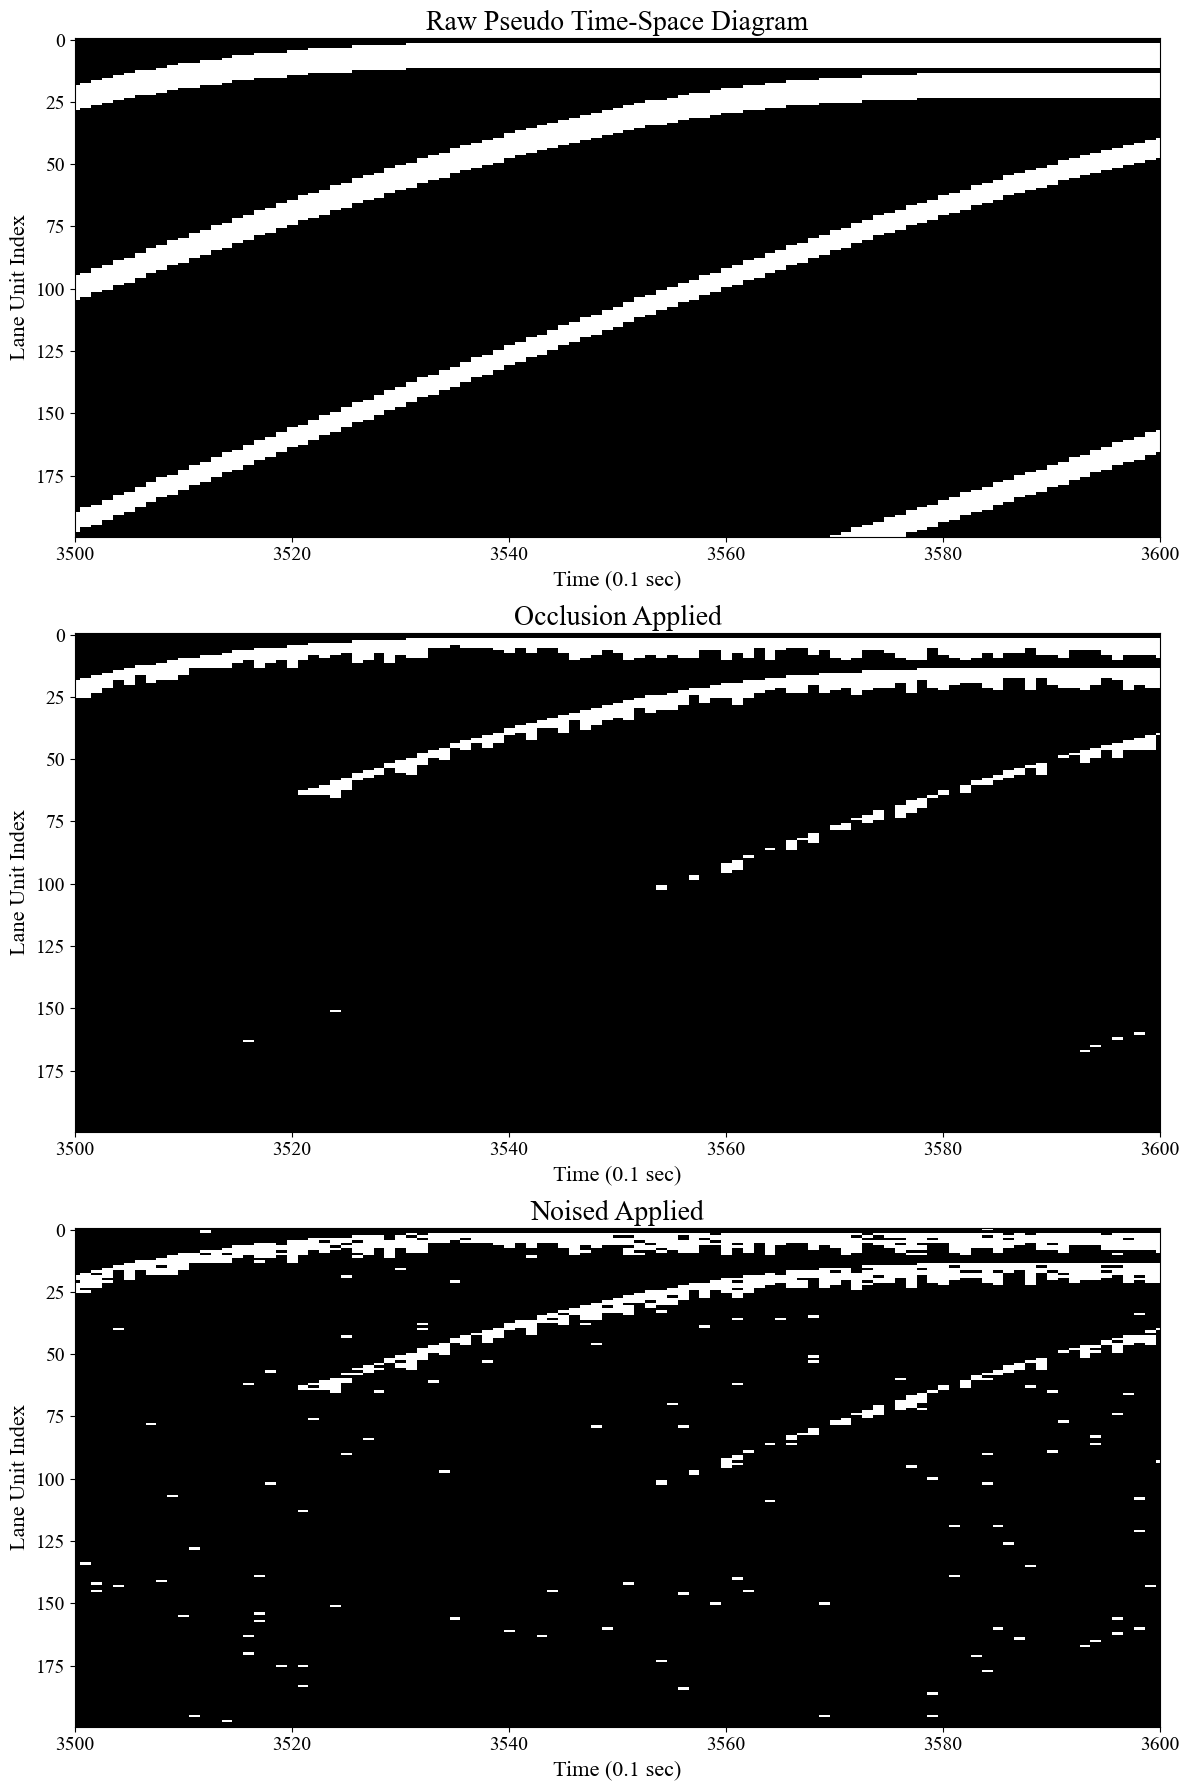

In [215]:
# set times new roman font
plt.rcParams["font.family"] = "Times New Roman"
# raw time-space diagram, occluded_diagram, noised, 3x1 grid
start_frame = red_light_time_start_timestamps[5] * 10
end_frame = start_frame + 100
plt.figure(figsize=(12, 18))
plt.subplot(3, 1, 1)
plt.imshow(time_space_mask, cmap='gray', aspect='auto', interpolation='none')
plt.title('Raw Pseudo Time-Space Diagram', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([start_frame, end_frame])
# plt.colorbar()
plt.subplot(3, 1, 2)
plt.imshow(occluded_diagram, cmap='gray', aspect='auto', interpolation='none')
plt.title('Occlusion Applied', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([start_frame, end_frame])

# plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(noised, cmap='gray', aspect='auto', interpolation='none')
plt.title('Noised Applied', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([start_frame, end_frame])

# plt.colorbar()
plt.tight_layout()
# plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\DataAugmentation.png', dpi = 300)
plt.show()


In [216]:
# Run simulation
lane_length = 100  # meters
simulation_time = 1800  # seconds
delta_t = 0.1  # seconds

red_light_time = 35
green_light_time = 35



mean_headway = 8
mean_speed = 10 
lane_change_prob = 0.06

In [218]:
from tqdm import tqdm

out_folder = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0913_5res_lanechange_signal'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
target_folder = os.path.join(out_folder, 'target')
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
post_occ_label_folder = os.path.join(out_folder, 'post_occ_label')
if not os.path.exists(post_occ_label_folder):
    os.makedirs(post_occ_label_folder)
speed_label_folder = os.path.join(out_folder, 'speed_label')
if not os.path.exists(speed_label_folder):
    os.makedirs(speed_label_folder)
traj_id_label_folder = os.path.join(out_folder, 'traj_id_label')
if not os.path.exists(traj_id_label_folder):
    os.makedirs(traj_id_label_folder)

delta_t = 0.1  # seconds
delta_x = 0.5  # meters
lane_length = 100  # meters
past_frames = 100
pred_frames = 100
simulation_repeat = 0
lane_change_prob = 0.1
total_sampled_flow_status = []
simulation_history = []
red_light_time = 35 + np.random.randint(-5, 5)
green_light_time = 35 + np.random.randint(-5, 5)
# signal simulation
# for red_light_time in tqdm(range(20, 75, 1)):
#     for green_light_time in range(red_light_time, 75, 1):
# for t in range(10):
for rep in tqdm(range(10000)):
    simulation_time = 20 * (red_light_time + green_light_time)  # seconds: 2 cycles
    mean_headway = 10 + np.random.normal(0,2) # seconds
    if mean_headway < 5:
        mean_headway = 5
    mean_speed = 10 + np.random.normal(0,4)# m/s
    if mean_speed < 5:
        mean_speed = 5
    vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob)

    total_vehicles = vehicles + exited_vehicles
    # After running the simulation
    time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(total_vehicles, lane_length, simulation_time, delta_t,delta_x)
    # upside down the grid
    time_space_mask = np.flipud(time_space_mask)
    time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
    occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
    noised = add_noise(occluded_diagram)

    speed_mask = np.zeros((time_space_mask.shape))
    for vehicle in vehicle_trajs:
        speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
    speed_mask = np.flipud(speed_mask)
    speed_mask = speed_mask.astype(np.float16)

    track_mask = np.zeros((time_space_mask.shape))
    for vehicle in vehicle_trajs:
        track_mask[vehicle[2],vehicle[1]] = 1
    track_mask = np.flipud(track_mask)
    track_mask = track_mask.astype(np.uint8)
    v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
    for vehicle in vehicle_trajs:
        v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
    v_id_mask = np.flipud(v_id_mask)
    v_id_mask = v_id_mask.astype(np.int16)

    np.save(os.path.join(target_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), track_mask)
    np.save(os.path.join(post_occ_label_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), noised)
    np.save(os.path.join(speed_label_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), speed_mask)
    np.save(os.path.join(traj_id_label_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), v_id_mask)
    
# # free flow simulation 
# for rep in tqdm(range(15000)):
#     simulation_time = 120
#     mean_headway = 15
#     mean_speed = 8 + np.random.rand() * 22
#     red_light_time = 0
#     green_light_time = 45
#     vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob)

#     total_vehicles = vehicles + exited_vehicles
#     # After running the simulation
#     time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(total_vehicles, lane_length, simulation_time, delta_t,delta_x)
#     # upside down the grid
#     time_space_mask = np.flipud(time_space_mask)
#     time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
#     occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
#     noised = add_noise(occluded_diagram)

#     speed_mask = np.zeros((time_space_mask.shape))
#     for vehicle in vehicle_trajs:
#         speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
#     speed_mask = np.flipud(speed_mask)
#     speed_mask = speed_mask.astype(np.float16)

#     track_mask = np.zeros((time_space_mask.shape))
#     for vehicle in vehicle_trajs:
#         track_mask[vehicle[2],vehicle[1]] = 1
#     track_mask = np.flipud(track_mask)
#     track_mask = track_mask.astype(np.uint8)
#     v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
#     for vehicle in vehicle_trajs:
#         v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
#     v_id_mask = np.flipud(v_id_mask)
#     v_id_mask = v_id_mask.astype(np.int16)

#     np.save(os.path.join(target_folder, f'{rep}_free.npy'), track_mask)
#     np.save(os.path.join(post_occ_label_folder, f'{rep}_free.npy'), noised)
#     np.save(os.path.join(speed_label_folder, f'{rep}_free.npy'), speed_mask)
#     np.save(os.path.join(traj_id_label_folder, f'{rep}_free.npy'), v_id_mask)

100%|██████████| 10000/10000 [1:32:05<00:00,  1.81it/s] 


In [83]:
# split into train and val set in 8:2 ratio
from tqdm import tqdm
import shutil
import random
import os

# out_folder = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0830'
time_span = 100
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
target_folder = os.path.join(out_folder, 'target')
post_occ_label_folder = os.path.join(out_folder, 'post_occ_label')
speed_label_folder = os.path.join(out_folder, 'speed_label')
traj_id_label_folder = os.path.join(out_folder, 'traj_id_label')

# get all the files
target_list = os.listdir(target_folder)
# shuffle the files
random.shuffle(target_list)
# split into train and val set
train_num = int(len(target_list) * 0.8)

train = target_list[:train_num]
val = target_list[train_num:]


out_folder_ = os.path.join(out_folder, f'{time_span}_frame')
train_folder = os.path.join(out_folder_, 'train')
val_folder = os.path.join(out_folder_, 'val')
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(val_folder):
    os.makedirs(val_folder)

train_target_folder = os.path.join(train_folder, 'target')
val_target_folder = os.path.join(val_folder, 'target')
train_post_occ_label_folder = os.path.join(train_folder, 'post_occ_label')
val_post_occ_label_folder = os.path.join(val_folder, 'post_occ_label')
train_speed_label_folder = os.path.join(train_folder, 'speed_label')
val_speed_label_folder = os.path.join(val_folder, 'speed_label')
train_traj_id_label_folder = os.path.join(train_folder, 'traj_id_label')
val_traj_id_label_folder = os.path.join(val_folder, 'traj_id_label')
if not os.path.exists(train_target_folder):
    os.makedirs(train_target_folder)
if not os.path.exists(val_target_folder):
    os.makedirs(val_target_folder)
if not os.path.exists(train_post_occ_label_folder):
    os.makedirs(train_post_occ_label_folder)
if not os.path.exists(val_post_occ_label_folder):
    os.makedirs(val_post_occ_label_folder)
if not os.path.exists(train_speed_label_folder):
    os.makedirs(train_speed_label_folder)
if not os.path.exists(val_speed_label_folder):
    os.makedirs(val_speed_label_folder)
if not os.path.exists(train_traj_id_label_folder):
    os.makedirs(train_traj_id_label_folder)
if not os.path.exists(val_traj_id_label_folder):
    os.makedirs(val_traj_id_label_folder)


# read and split the array according to the time span and save to the corresponding folder
for arr in tqdm(train):
    target = np.load(os.path.join(target_folder, arr))
    post_occ_label = np.load(os.path.join(post_occ_label_folder, arr))
    speed_label = np.load(os.path.join(speed_label_folder, arr))
    v_id_mask = np.load(os.path.join(traj_id_label_folder, arr))

    # check if the array is long enough
    if target.shape[1] < time_span:
        continue
    # check if same size of the array
    assert target.shape[1] == post_occ_label.shape[1] == speed_label.shape[1] == v_id_mask.shape[1] 
    
    for t in range(time_span,target.shape[1],time_span):

        target_t = target[:,t - time_span:t]
        post_occ_label_t = post_occ_label[:,t - time_span:t]
        speed_label_t = speed_label[:,t - time_span:t]
        v_id_mask_t = v_id_mask[:,t - time_span:t]
        
        np.save(os.path.join(train_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(train_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(train_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(train_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)

for arr in tqdm(val):

    target = np.load(os.path.join(target_folder, arr))
    post_occ_label = np.load(os.path.join(post_occ_label_folder, arr))
    speed_label = np.load(os.path.join(speed_label_folder, arr))
    v_id_mask = np.load(os.path.join(traj_id_label_folder, arr))
    # check if the array is long enough
    if target.shape[1] < time_span:
        continue
    # check if same size of the array
    assert target.shape[1] == post_occ_label.shape[1] == speed_label.shape[1] == v_id_mask.shape[1]
    
    for t in range(time_span,target.shape[1],time_span):

        target_t = target[:,t - time_span:t]
        post_occ_label_t = post_occ_label[:,t - time_span:t]
        speed_label_t = speed_label[:,t - time_span:t]
        v_id_mask_t = v_id_mask[:,t - time_span:t]
        np.save(os.path.join(val_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(val_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(val_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(val_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    

100%|██████████| 6080/6080 [08:08<00:00, 12.46it/s]  


In [219]:
# split into train and val set in 8:2 ratio
from tqdm import tqdm
import shutil
import random
import os

# out_folder = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0830'
time_span = 100
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
target_folder = os.path.join(out_folder, 'target')
post_occ_label_folder = os.path.join(out_folder, 'post_occ_label')
speed_label_folder = os.path.join(out_folder, 'speed_label')
traj_id_label_folder = os.path.join(out_folder, 'traj_id_label')

# get all the files
target_list = os.listdir(target_folder)
# shuffle the files
random.shuffle(target_list)
# split into train and val set
train_num = int(len(target_list) * 0.8)

train = target_list[:train_num]
val = target_list[train_num:]


out_folder_ = os.path.join(out_folder, f'{time_span}_frame')
train_folder = os.path.join(out_folder_, 'train')
val_folder = os.path.join(out_folder_, 'val')
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(val_folder):
    os.makedirs(val_folder)

train_target_folder = os.path.join(train_folder, 'target')
val_target_folder = os.path.join(val_folder, 'target')
train_post_occ_label_folder = os.path.join(train_folder, 'post_occ_label')
val_post_occ_label_folder = os.path.join(val_folder, 'post_occ_label')
train_speed_label_folder = os.path.join(train_folder, 'speed_label')
val_speed_label_folder = os.path.join(val_folder, 'speed_label')
train_traj_id_label_folder = os.path.join(train_folder, 'traj_id_label')
val_traj_id_label_folder = os.path.join(val_folder, 'traj_id_label')
if not os.path.exists(train_target_folder):
    os.makedirs(train_target_folder)
if not os.path.exists(val_target_folder):
    os.makedirs(val_target_folder)
if not os.path.exists(train_post_occ_label_folder):
    os.makedirs(train_post_occ_label_folder)
if not os.path.exists(val_post_occ_label_folder):
    os.makedirs(val_post_occ_label_folder)
if not os.path.exists(train_speed_label_folder):
    os.makedirs(train_speed_label_folder)
if not os.path.exists(val_speed_label_folder):
    os.makedirs(val_speed_label_folder)
if not os.path.exists(train_traj_id_label_folder):
    os.makedirs(train_traj_id_label_folder)
if not os.path.exists(val_traj_id_label_folder):
    os.makedirs(val_traj_id_label_folder)

red_sameple_prob = 0.2
green_sameple_prob = 1 - red_sameple_prob
# read and split the array according to the time span and save to the corresponding folder
for arr in tqdm(train):
    target = np.load(os.path.join(target_folder, arr))
    post_occ_label = np.load(os.path.join(post_occ_label_folder, arr))
    speed_label = np.load(os.path.join(speed_label_folder, arr))
    v_id_mask = np.load(os.path.join(traj_id_label_folder, arr))

    # check if the array is long enough
    if target.shape[1] < time_span:
        continue
    # check if same size of the array
    assert target.shape[1] == post_occ_label.shape[1] == speed_label.shape[1] == v_id_mask.shape[1]
    red_light_time = int(red_light_time)
    green_light_time = int(green_light_time)
    total_sim_time = target.shape[1] * 0.1

    red_light_time_start_timestamps = np.arange(0, 15*70, red_light_time + green_light_time)
    red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time
    freeflow_timestamps = (red_light_time_start_timestamps[1:] + red_light_time_end_timestamps[:-1]) / 2

    # convert to frame number
    # this represents the queue forming time
    red_light_time_start_frames = (red_light_time_start_timestamps * 10).astype(int)
    # this represents the queue dissolving time
    red_light_time_end_frames = (red_light_time_end_timestamps * 10).astype(int)
    # this represents the free flow time
    freeflow_frames = (freeflow_timestamps * 10).astype(int)


    # We only focus on the queue forming and dissolving processes
    # Queue forming
    for t in red_light_time_start_frames:
        if t + time_span > target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        
        np.save(os.path.join(train_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(train_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(train_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(train_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    # Queue dissolving
    for t in red_light_time_end_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span] 
        
        np.save(os.path.join(train_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(train_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(train_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(train_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    # Free flow
    for t in freeflow_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span] 
        
        np.save(os.path.join(train_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(train_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(train_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(train_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)

for arr in tqdm(val):

    target = np.load(os.path.join(target_folder, arr))
    post_occ_label = np.load(os.path.join(post_occ_label_folder, arr))
    speed_label = np.load(os.path.join(speed_label_folder, arr))
    v_id_mask = np.load(os.path.join(traj_id_label_folder, arr))
    # check if the array is long enough
    if target.shape[1] < time_span:
        continue
    # check if same size of the array
    assert target.shape[1] == post_occ_label.shape[1] == speed_label.shape[1] == v_id_mask.shape[1]

    red_light_time = int(red_light_time)
    green_light_time = int(green_light_time)
    total_sim_time = target.shape[1] * 0.1

    red_light_time_start_timestamps = np.arange(0, 15*70, red_light_time + green_light_time)
    red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time
    freeflow_timestamps = (red_light_time_start_timestamps[1:] + red_light_time_end_timestamps[:-1]) / 2

    # convert to frame number
    # this represents the queue forming time
    red_light_time_start_frames = (red_light_time_start_timestamps * 10).astype(int)
    # this represents the queue dissolving time
    red_light_time_end_frames = (red_light_time_end_timestamps * 10).astype(int)
    # this represents the free flow time
    freeflow_frames = (freeflow_timestamps * 10).astype(int)

    for t in red_light_time_start_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        np.save(os.path.join(val_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(val_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(val_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(val_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    
    for t in red_light_time_end_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        np.save(os.path.join(val_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(val_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(val_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(val_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    for t in freeflow_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        np.save(os.path.join(val_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(val_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(val_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(val_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)


100%|██████████| 2003/2003 [05:36<00:00,  5.96it/s]


In [203]:
red_light_time = int(red_light_time)
green_light_time = int(green_light_time)
total_sim_time = target.shape[1] * 0.1

red_light_time_start_timestamps = np.arange(0, 15*70, red_light_time + green_light_time)
red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time
freeflow_timestamps = (red_light_time_start_timestamps[1:] + red_light_time_end_timestamps[:-1]) / 2

# convert to frame number
# this represents the queue forming time
red_light_time_start_frames = (red_light_time_start_timestamps * 10).astype(int)
# this represents the queue dissolving time
red_light_time_end_frames = (red_light_time_end_timestamps * 10).astype(int)
# this represents the free flow time
freeflow_frames = (freeflow_timestamps * 10).astype(int)


In [38]:
red_light_time = int(30 + 15) # seconds
green_light_time = int(60 + 15) # seconds
t = 0
simulation_time = 2 * (red_light_time + green_light_time)  # seconds: 2 cycles
delta_x = 0.5
mean_headway = 9
mean_speed = 12
lane_change_prob = 0.1
vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob )

total_vehicles = vehicles + exited_vehicles
# After running the simulation
time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(total_vehicles, lane_length, simulation_time, delta_t,delta_x)
# upside down the grid
time_space_mask = np.flipud(time_space_mask)
time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
noised = add_noise(occluded_diagram, emit_rate=0.1, noise_rate=0.01)

# noised = np.flipud(noised)
speed_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
speed_mask = np.flipud(speed_mask)
track_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    track_mask[vehicle[2],vehicle[1]] = 1
track_mask = np.flipud(track_mask)
v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
for vehicle in vehicle_trajs:
    v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
v_id_mask = np.flipud(v_id_mask)

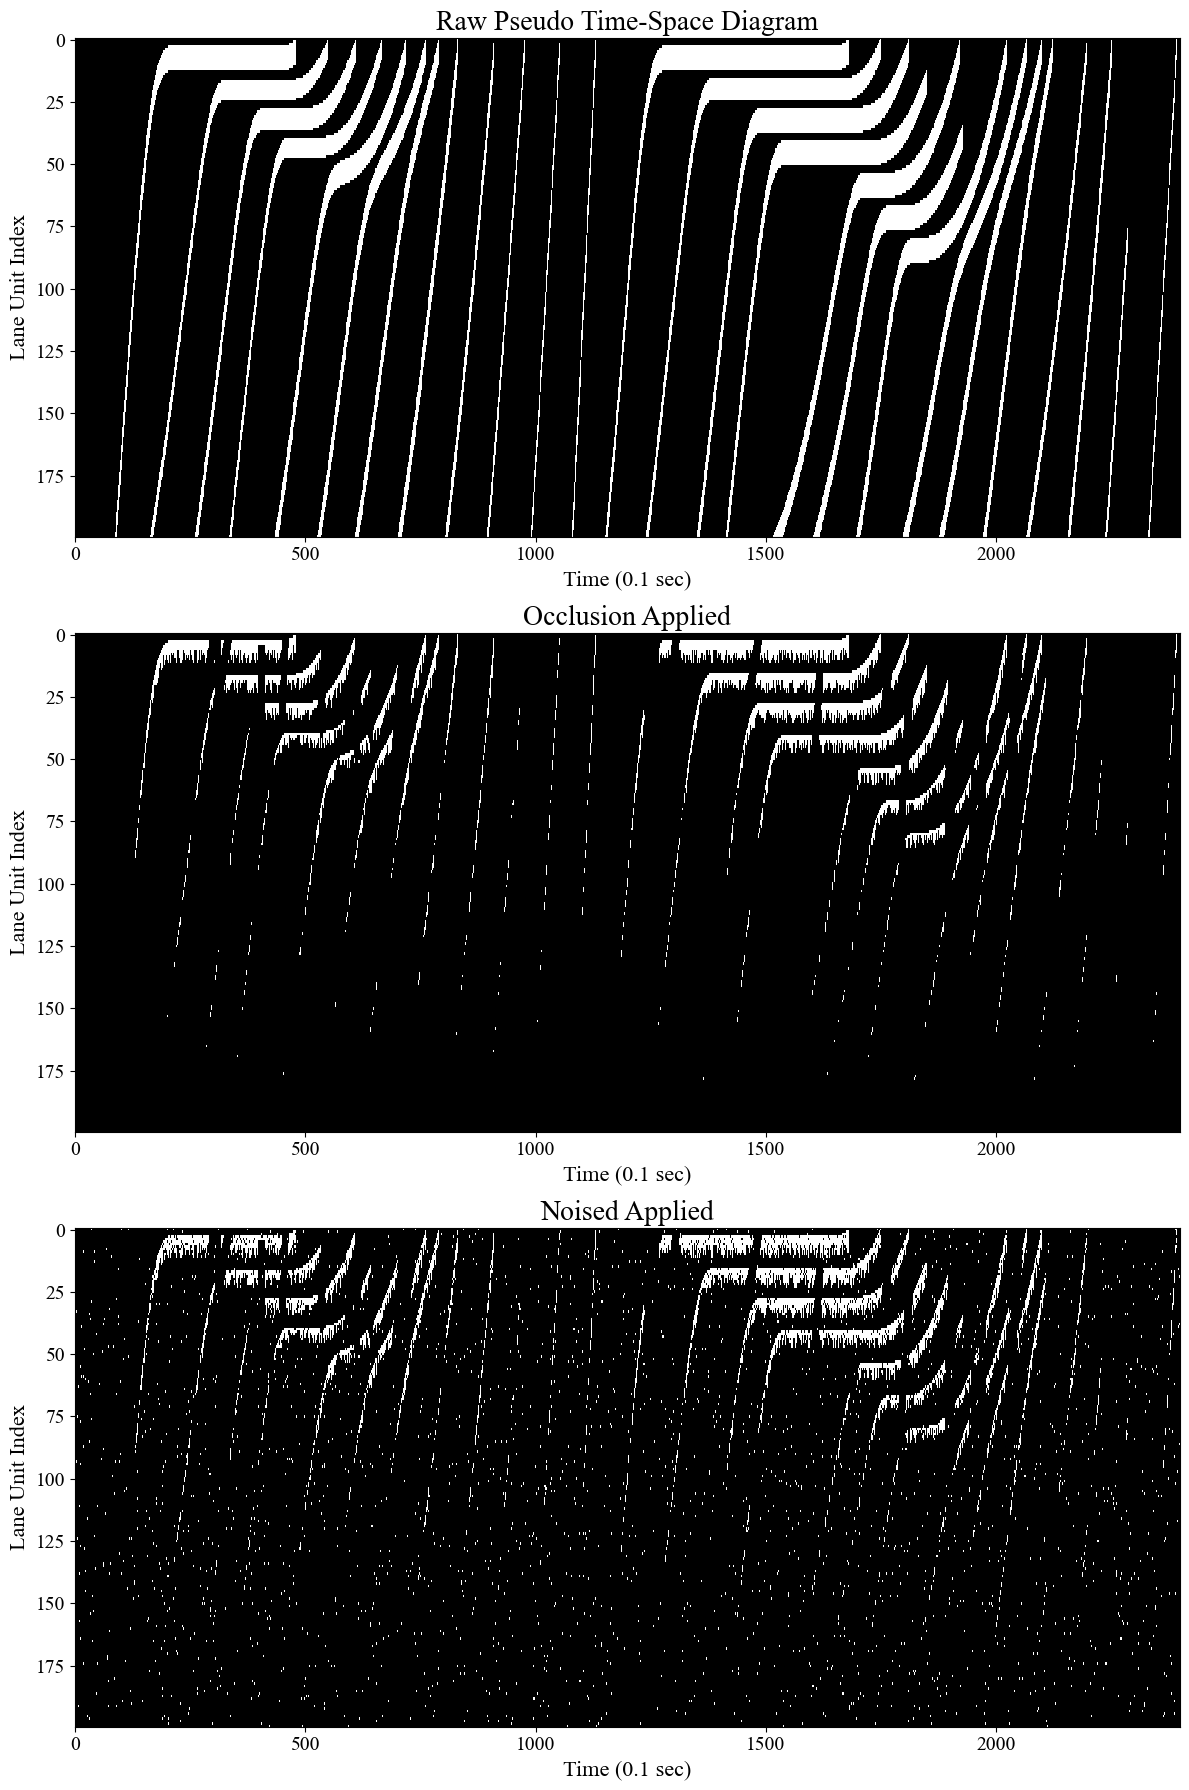

In [39]:
# set times new roman font
plt.rcParams["font.family"] = "Times New Roman"
# raw time-space diagram, occluded_diagram, noised, 3x1 grid
plt.figure(figsize=(12, 18))
plt.subplot(3, 1, 1)
plt.imshow(time_space_mask, cmap='gray', aspect='auto', interpolation='none')
plt.title('Raw Pseudo Time-Space Diagram', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.colorbar()
plt.subplot(3, 1, 2)
plt.imshow(occluded_diagram, cmap='gray', aspect='auto', interpolation='none')
plt.title('Occlusion Applied', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(noised, cmap='gray', aspect='auto', interpolation='none')
plt.title('Noised Applied', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.colorbar()
plt.tight_layout()
# plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\DataAugmentation.png', dpi = 300)
plt.show()
